# OpenCV vs Composable Overlay 

<div class="alert alert-box alert-info">
Please use Jupyter labs http://&lt;board_ip_address&gt;/lab for this notebook.
</div>


## Aims
* Compare a pure OpenCV pipeline with a composable pipeline

## Table of Contents
* [Software Video Pipeline](#sw)
* [Hardware Video Pipeline](#hw)
* [Conclusion](#conclusion)

----

## Revision History

* v1.0 | 04 March 2024 | First notebook revision.

## Software Video Pipeline <a class="anchor" id="sw"></a>

In [1]:
import cv2
import numpy as np
import PIL.Image
from pynq.lib.video import VideoMode
import time

Setup video mode

In [2]:
mode = VideoMode(1280, 720, 24, 60)

Open and configure the webcam

In [3]:
webcam = cv2.VideoCapture(0 + cv2.CAP_V4L2)
webcam.set(cv2.CAP_PROP_FRAME_WIDTH, mode.width)
webcam.set(cv2.CAP_PROP_FRAME_HEIGHT, mode.height)
webcam.set(cv2.CAP_PROP_FPS, mode.fps)

True

Check webcamera status

In [4]:
ret, frame = webcam.read()
if not ret:
    print('Camera cannot be open')

In [5]:
def show_image(frame):
    return PIL.Image.fromarray(frame[:,:,[2,1,0]])

Define function to implement color detect pipeline

In [6]:
kernel = np.ones((3,3), np.uint8)
def run_sw_pipeline():
    ret, frame = webcam.read()
    frame_hsv = cv2.cvtColor(frame, cv2.COLOR_RGB2HSV)
    #frame_threshold0 = cv2.inRange(frame_hsv, (22, 38, 160), (38, 75, 179))
    #frame_threshold1 = cv2.inRange(frame_hsv, (150, 150, 150), (255, 255, 255))
    frame_threshold2 = cv2.inRange(frame_hsv, (60, 60, 60), (255, 255, 255))
    #frame_threshold = frame_threshold0 | frame_threshold1 | frame_threshold2
    erode_0 = cv2.erode(frame_threshold2, kernel, iterations=1)
    dilate_0 = cv2.erode(erode_0, kernel, iterations=1)
    dilate_1 = cv2.erode(dilate_0, kernel, iterations=1)
    erode_1 = cv2.erode(dilate_1, kernel, iterations=1)
    frame_rgb = cv2.cvtColor(erode_1, cv2.COLOR_GRAY2RGB)
    return frame_rgb & frame

Check software pipeline

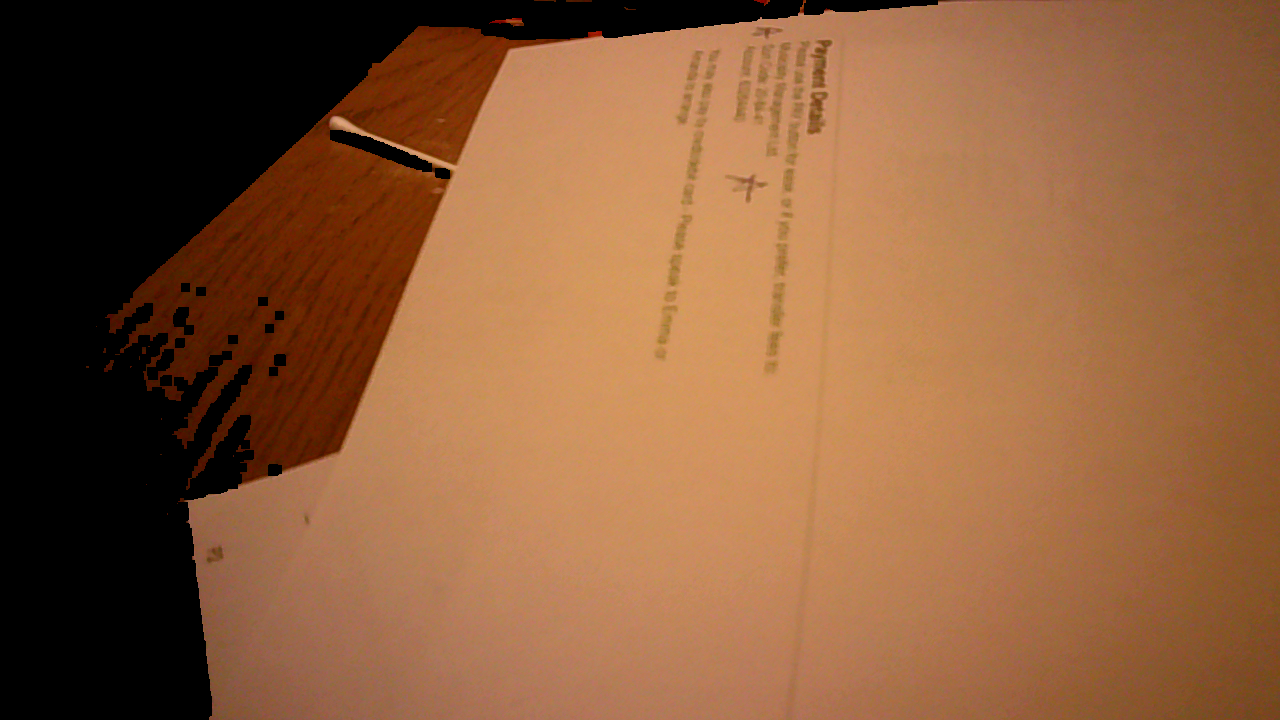

In [7]:
res = run_sw_pipeline()
show_image(res)

Run software pipeline for several frames to get frames per second

In [8]:
frames = 120
start_time = time.time()
for _ in range(frames):
    res = run_sw_pipeline()
end_time = time.time()

print("Took {:.3f} seconds to process {} frames. Software achieved {:.2f} FPS".format(ex_time := end_time-start_time, frames, frames/ex_time))

Took 11.703 seconds to process 120 frames. Software achieved 10.25 FPS


## Hardware Video Pipeline <a class="anchor" id="hw"></a>

In [9]:
from pynq import Overlay
import pynq_composable

Download overlay and create objects

In [10]:
ol = Overlay("cv_dfx_3_pr.bit")

cpipe = ol.composable

Define objects to control the DMA

In [11]:
writechannel = ol.video.axi_vdma.writechannel
readchannel = ol.video.axi_vdma.readchannel
writechannel.mode = mode
readchannel.mode = mode
writechannel.start()
readchannel.start()

AttributeError: attribute 'device' of 'numpy.ndarray' objects is not writable

Download partial bitstreams and compose pipeline

In [ ]:
cpipe.load('pr_0/dilate_accel')
cpipe.load('pr_1/dilate_accel')
cpipe.load('pr_2/bitwise_and_accel')

pipeline = [cpipe.ps_video_in, cpipe.duplicate_accel,
            [[cpipe.rgb2hsv_accel, cpipe.colorthresholding_accel, cpipe.pr_0.erode_accel,
              cpipe.pr_0.dilate_accel, cpipe.pr_1.dilate_accel, cpipe.pr_1.erode_accel,
              cpipe.gray2rgb_accel], [1]],
            cpipe.pr_2.bitwise_and_accel, cpipe.ps_video_out]

cpipe.compose(pipeline)
cpipe.graph

Run hardware pipeline via the VDMA

In [ ]:
def run_hw_pipeline():
    fpgaframe = writechannel.newframe()
    _, fpgaframe[:] = webcam.read()
    writechannel.writeframe(fpgaframe)
    res = readchannel.readframe()
    return res

Run software pipeline for several frames to get frames per second

In [ ]:
frames = 120
start_time = time.time()
for _ in range(frames):
    res = run_hw_pipeline()
end_time = time.time()

print("Took {:.3f} seconds to process {} frames. Hardware achieved {:.2f} FPS".format(ex_time := end_time-start_time, frames, frames/ex_time))

Release the camera and overlay

In [12]:
webcam.release()
ol.free()

## Conclusion <a class="anchor" id="conclusion"></a>

This notebooks showed the performance of a software video pipeline and a hardware video pipeline

Copyright &copy; 2024 AMD, Inc

SPDX-License-Identifier: BSD-3-Clause

----